# Let's practice !
In this exercice, you will implement a vertical 2D jumper that must reach a height of 1 meter with one torque-actuated leg made of two segments.
The vertical degree of freedom actuation must be forced to zero, to mimic free flying conditions.
The lower segment of the leg must be constrained with a contact point in the first phase which will then be released in the second phase.
The main objective is to minimize torques during each phase.
The first phase will last for 0.2s with 40 nodes and the second will last for 0.4s with 40 nodes.

The motion will look like this :

![SegmentLocal](img/slider.gif)

In [9]:
import numpy as np
import biorbd_casadi as biorbd
from bioptim import *

In [10]:
model = biorbd.Model("models/Slider1Leg.bioMod"), biorbd.Model("models/Slider1Leg.bioMod")
nq = model[0].nbQ()
ntau = model[0].nbGeneralizedTorque()

# This is your turn
n_shooting = 40, 40
final_time = 0.2, 0.4
tau_min, tau_max, tau_init = -200, 200, 0

dynamics = DynamicsList()
dynamics.add(DynamicsFcn.TORQUE_DRIVEN, with_contact=True)
dynamics.add(DynamicsFcn.TORQUE_DRIVEN)

objective_functions = ObjectiveList()
objective_functions.add(ObjectiveFcn.Lagrange.MINIMIZE_CONTROL, key="tau", weight=0.1, phase=0)
objective_functions.add(ObjectiveFcn.Lagrange.MINIMIZE_CONTROL, key="tau", weight=0.1, phase=1)

x_bounds = BoundsList()
x_bounds.add(bounds=QAndQDotBounds(model[0]))
x_bounds.add(bounds=QAndQDotBounds(model[1]))

x_bounds[0][:3, 0] = [0, 3*np.pi / 8, -3*np.pi / 4]
x_bounds[0][3:, 0] = 0
x_bounds[0].min[0, -1] = 0
x_bounds[0].max[0, -1] = 0.25

x_bounds[1][0, -1] = 1
x_bounds[1][3, -1] = 0

u_bounds = BoundsList()
u_bounds.add([tau_min] * ntau, [tau_max] * ntau)
u_bounds.add([tau_min] * ntau, [tau_max] * ntau)

u_bounds[0][0, :] = 0
u_bounds[1][0, :] = 0

x_init = InitialGuessList()
x_init.add([0, 3*np.pi / 8, -3*np.pi / 4] + [0] * nq)
x_init.add([0, 0, 0] + [0] * nq)

u_init = InitialGuessList()
u_init.add([tau_init] * ntau)
u_init.add([tau_init] * ntau)

# Constraints
constraints = ConstraintList()
constraints.add(
    ConstraintFcn.TRACK_CONTACT_FORCES,
    min_bound=0,
    max_bound=np.inf,
    node=Node.ALL_SHOOTING,
    contact_index=0,  # z axis
)

ocp = OptimalControlProgram(
    model,
    dynamics,
    n_shooting,
    final_time,
    x_init,
    u_init,
    x_bounds,
    u_bounds,
    objective_functions=objective_functions,
    constraints=constraints,
    n_threads=8,
)

# have a look on the optimal control problem
ocp.print(to_console=False, to_graph=False)

In [11]:
sol = ocp.solve()

This is Ipopt version 3.14.10, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:     4094
Number of nonzeros in inequality constraint Jacobian.:      314
Number of nonzeros in Lagrangian Hessian.............:     2527

Total number of variables............................:      644
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      644
                     variables with only upper bounds:        0
Total number of equality constraints.................:      486
Total number of inequality constraints...............:       40
        inequality constraints with only lower bounds:       40
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.35e+00 3.26e-03  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

Solver reported time: 2.39121978 sec
Real time: 2.391630382000585 sec

---- COST FUNCTION VALUES ----
PHASE 0
MINIMIZE_CONTROL:  763.23 (weighted 169.1422464375459)

PHASE 1
MINIMIZE_CONTROL: -833.70 (weighted 42.66820366490694)

Sum cost functions: 211.81045010245285
------------------------------

--------- CONSTRAINTS ---------
PHASE 0
CONTINUITY: 1.2487907843222734e-12
PHASE_TRANSITION 0->1: 0.0
TRACK_CONTACT_FORCES: 2105.9877252714678

PHASE 1
CONTINUITY: -1.0818573508552132e-12

------------------------------


/home/fb/miniconda3/envs/bioptim/lib/python3.10/site-packages/bioptim/optimization/solution.py:769: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time_vector.append(sum(time_phase[: p + 1]) + np.array(flat_time))
/home/fb/miniconda3/envs/bioptim/lib/python3.10/site-packages/bioptim/gui/plot.py:896: RuntimeWarning: All-NaN axis encountered
  y_min = min(y_min, np.nanmin(p.get_ydata()))
/home/fb/miniconda3/envs/bioptim/lib/python3.10/site-packages/bioptim/gui/plot.py:897: RuntimeWarning: All-NaN axis encountered
  y_max = max(y_max, np.nanmax(p.get_ydata()))


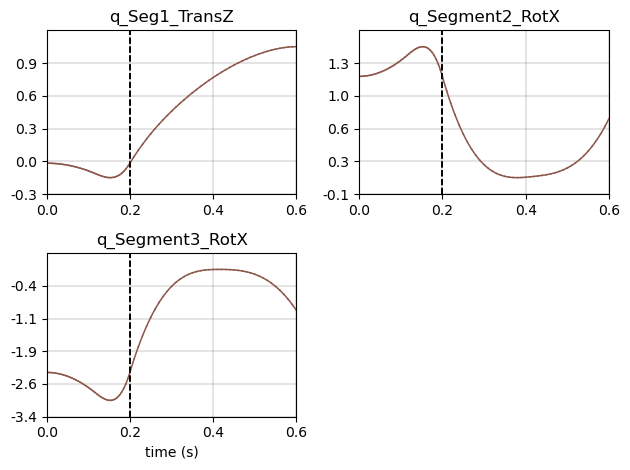

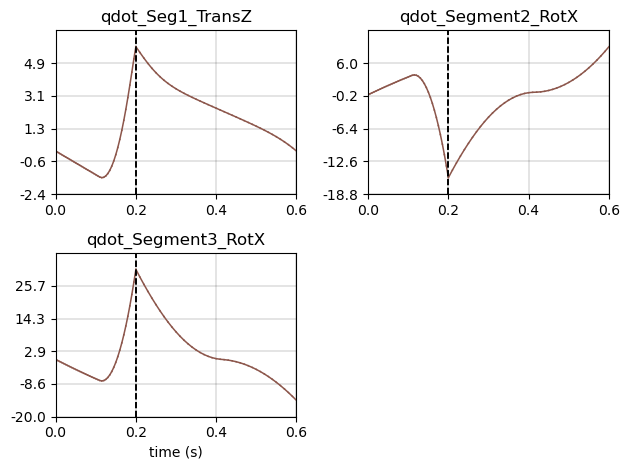

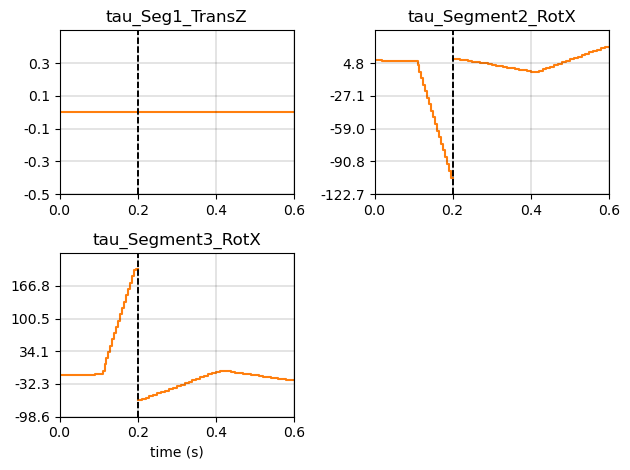

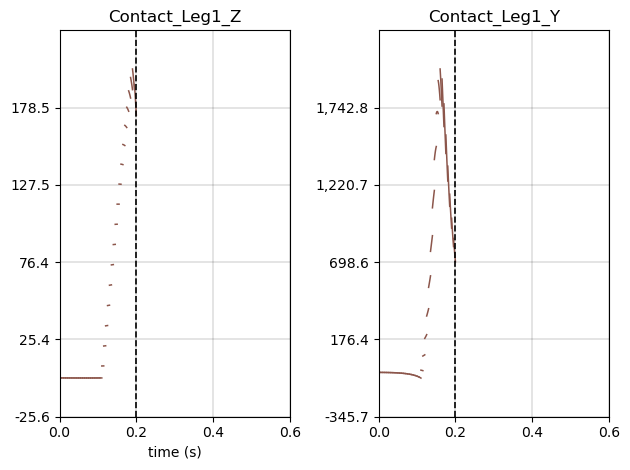

In [12]:
sol.print_cost()
sol.graphs(automatically_organize=False)

In [13]:
sol.animate()